# **Fase 1: Comprensión del Negocio** 📈


## **1. Introducción: Contexto y Problema de Negocio**

 En el dinámico mundo del comercio electrónico, la capacidad de predecir el éxito de un producto es una ventaja competitiva clave. Una empresa que puede identificar con antelación a sus productos más vendidos (`bestsellers`) puede tomar decisiones informadas sobre el inventario, optimizar sus campañas de marketing y mejorar la rentabilidad general.

 El problema que resolveremos es un problema de clasificación: desarrollar un modelo que, basándose en las características de un producto, pueda predecir si este se convertirá en un _bestseller_.

## **2. Objetivo de Machine Learning**

 El objetivo es crear un modelo de clasificación que tome como entrada las características de un producto y determine si la variable `isBestSeller` es `True` o `False`.

 * **Entradas (_features_)**: Información clave de los productos, como:
     * `price` (precio)
     * `discounted_price` (precio con descuento)
     * `rating` (valoración)
     * `rating_count` (número de valoraciones)
     * `category` (categoría del producto)
 * **Salida (_target_)**: La variable **`isBestSeller`**, que indica si un producto ha alcanzado el estatus de _bestseller_.

## Importación de las librerias 

In [11]:
import pandas as pd
import numpy as np
import re
import os
from matplotlib import pyplot as plt
import seaborn as sns

# FASE 2: Carga y exploración
 ## Carga de datasets

In [12]:
# Ruta base corregida
base_path = r"C:\Users\jgtot\Desktop\ML_proyecto\amazon-best\data\01_raw"

# Rutas completas
amazon_path = os.path.join(base_path, 'amazon.csv')
amazon_products_path = os.path.join(base_path, 'amazon_products.csv')
amazon_categories_path = os.path.join(base_path, 'amazon_categories.csv')
products_path = os.path.join(base_path, 'products.csv')

# Cargar todos los datasets
df_amazon = pd.read_csv(amazon_path)
df_products = pd.read_csv(amazon_products_path)
df_categories = pd.read_csv(amazon_categories_path)
df_extra_products = pd.read_csv(products_path)

print("✅ Todos los datasets fueron cargados correctamente:")
print("amazon.csv:", df_amazon.shape)
print("amazon_products.csv:", df_products.shape)
print("amazon_categories.csv:", df_categories.shape)
print("products.csv:", df_extra_products.shape)

✅ Todos los datasets fueron cargados correctamente:
amazon.csv: (1465, 16)
amazon_products.csv: (1426337, 11)
amazon_categories.csv: (248, 2)
products.csv: (13156, 8)


## Columnas y tipos de datos 

In [13]:
for name, df in zip(['amazon', 'amazon_products', 'amazon_categories', 'products'],
                    [df_amazon, df_products, df_categories, df_extra_products]):
    print(f"\n📦 {name}")
    print("Columnas:", df.columns.tolist())

    # Mostrar tipos de datos de cada DataFrame
for name, df in zip(['amazon', 'amazon_products', 'amazon_categories', 'products'],
                    [df_amazon, df_products, df_categories, df_extra_products]):
    print(f"\n📦 Tipos de datos en {name}")
    print(df.dtypes)


📦 amazon
Columnas: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']

📦 amazon_products
Columnas: ['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth']

📦 amazon_categories
Columnas: ['id', 'category_name']

📦 products
Columnas: ['product_id', 'brand', 'title', 'price', 'category', 'rating', 'image_url', 'product_url']

📦 Tipos de datos en amazon
product_id             object
product_name           object
category               object
discounted_price       object
actual_price           object
discount_percentage    object
rating                 object
rating_count           object
about_product          object
user_id                object
user_name              object
review_id              object
review_title  

## Valores nulos

In [14]:
for name, df in zip(['amazon', 'amazon_products', 'amazon_categories', 'products'],
                    [df_amazon, df_products, df_categories, df_extra_products]):
    print(f"\n🔍 Valores nulos en {name}")
    print(df.isnull().sum())


🔍 Valores nulos en amazon
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

🔍 Valores nulos en amazon_products
asin                 0
title                1
imgUrl               0
productURL           0
stars                0
reviews              0
price                0
listPrice            0
category_id          0
isBestSeller         0
boughtInLastMonth    0
dtype: int64

🔍 Valores nulos en amazon_categories
id               0
category_name    0
dtype: int64

🔍 Valores nulos en products
product_id       0
brand            1
title            1
price          193
category         0
rating         883
image_url        0
product

## Datos duplicados 

In [15]:
# Verificar duplicados en cada DataFrame
for name, df in zip(['amazon', 'amazon_products', 'amazon_categories', 'products'],
                    [df_amazon, df_products, df_categories, df_extra_products]):
    total = df.shape[0]
    duplicates = df.duplicated().sum()
    print(f"\n📦 {name}")
    print(f"Total de filas: {total}")
    print(f"Duplicados encontrados: {duplicates}")
    print(f"Porcentaje duplicado: {round(duplicates / total * 100, 2)}%")


📦 amazon
Total de filas: 1465
Duplicados encontrados: 0
Porcentaje duplicado: 0.0%

📦 amazon_products
Total de filas: 1426337
Duplicados encontrados: 0
Porcentaje duplicado: 0.0%

📦 amazon_categories
Total de filas: 248
Duplicados encontrados: 0
Porcentaje duplicado: 0.0%

📦 products
Total de filas: 13156
Duplicados encontrados: 667
Porcentaje duplicado: 5.07%


## Caracteres especiales

In [16]:
def detectar_caracteres_especiales(df, nombre_df):
    print(f"\n🔍 Verificando caracteres especiales en: {nombre_df}")
    for col in df.select_dtypes(include='object').columns:
        # Buscar patrones no alfanuméricos
        especiales = df[col].dropna().apply(lambda x: bool(re.search(r'[^\w\s]', str(x))))
        if especiales.any():
            print(f"⚠️ Columna '{col}' contiene caracteres especiales.")
        else:
            print(f"✅ Columna '{col}' sin caracteres especiales.")

# Aplicar a cada DataFrame
detectar_caracteres_especiales(df_amazon, 'amazon')
detectar_caracteres_especiales(df_products, 'amazon_products')
detectar_caracteres_especiales(df_categories, 'amazon_categories')
detectar_caracteres_especiales(df_extra_products, 'products')


🔍 Verificando caracteres especiales en: amazon
✅ Columna 'product_id' sin caracteres especiales.
⚠️ Columna 'product_name' contiene caracteres especiales.
⚠️ Columna 'category' contiene caracteres especiales.
⚠️ Columna 'discounted_price' contiene caracteres especiales.
⚠️ Columna 'actual_price' contiene caracteres especiales.
⚠️ Columna 'discount_percentage' contiene caracteres especiales.
⚠️ Columna 'rating' contiene caracteres especiales.
⚠️ Columna 'rating_count' contiene caracteres especiales.
⚠️ Columna 'about_product' contiene caracteres especiales.
⚠️ Columna 'user_id' contiene caracteres especiales.
⚠️ Columna 'user_name' contiene caracteres especiales.
⚠️ Columna 'review_id' contiene caracteres especiales.
⚠️ Columna 'review_title' contiene caracteres especiales.
⚠️ Columna 'review_content' contiene caracteres especiales.
⚠️ Columna 'img_link' contiene caracteres especiales.
⚠️ Columna 'product_link' contiene caracteres especiales.

🔍 Verificando caracteres especiales en: am

## Muestra de datos

In [17]:
from IPython.display import display, Markdown

# Función para mostrar muestra con estilo
def mostrar_muestra(df, nombre_df):
    display(Markdown(f"### 📄 Muestra de `{nombre_df}`"))
    display(df.sample(5, random_state=42))

# Mostrar muestras de cada dataset
mostrar_muestra(df_amazon, 'amazon')
mostrar_muestra(df_products, 'amazon_products')
mostrar_muestra(df_categories, 'amazon_categories')
mostrar_muestra(df_extra_products, 'products')

### 📄 Muestra de `amazon`

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
976,B09XXZXQC1,Xiaomi Pad 5| Qualcomm Snapdragon 860| 120Hz R...,Computers&Accessories|Tablets,"₹26,999","₹37,999",29%,4.6,"2,886",Qualcomm Snapdragon 860 Octa-core processor | ...,"AGIQYUS55MG4UWXTEF4PRMPZWPQA,AH4VWAKSTYSTM4XW5...","& I Am IronMan,Amazon Customer,Sayandeep Sarka...","R2BT60BZIDC986,R17KDJGM0QOT3P,R2U9CP6B4FEVBN,R...",the only ANDROID tablet that makes sense in th...,first i would like to comment on the tab marke...,https://m.media-amazon.com/images/I/31jUKdJdjH...,https://www.amazon.in/Snapdragon-Resolution-Re...
175,B09LHXNZLR,"Skadioo WiFi Adapter for pc | Car Accessories,...",Computers&Accessories|NetworkingDevices|Networ...,₹199,₹499,60%,3.7,612,【Powerful compatibility】 Compatible with TV bo...,"AG2Q7FISK54KBSPHF7CNNGZ3GLNA,AFFYX3FR3SF4JOIN7...","POTNURU RAJINI,swapnil mohit masih,Suryansh Bh...","R3U57AW0L6O5C6,R3FCLH5G7XVDU4,R39PNKDT86WK5V,R...","Good,Very nice,Best quality,Not bad,Best WiFi ...","Good,Its working is very nice with pc. Easy to...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Skadioo-Accessories-Rece...
275,B09LV13JFB,LOHAYA Voice Assistant Remote Compatible for A...,"Electronics|HomeTheater,TV&Video|Accessories|R...",₹399,₹999,60%,3.3,23,100% Best Quality Plastic Body and Soft Silico...,"AERUC72DWRPOM2EHX3YBTBPKYV7A,AHMH6RNLYI2G65HY7...","Amazon Customer,Amazon Customer,Akul,Akash Yad...","R1P2VLNHZAHSCU,R28B2GC0X0RMKW,RQ2S0N0NGDQVY,R1...",When I placed the order I was in doubt whether...,"Ok,Very disappointedRange is not good it doesn...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/LOHAYA-Assistant-Compati...
548,B08M66K48D,POPIO Tempered Glass Screen Protector Compatib...,Electronics|Mobiles&Accessories|MobileAccessor...,₹299,₹599,50%,4.3,"4,674",Hardness: High hardness level provides protect...,"AHH26HAPTOI5Z52DFLNYU5TOLWCQ,AFIPAA4KT36MSZTCV...","Ram K,Ankush,Viswanathan,Sanchita Mandal,Malho...","R2K2YNHJ952H5J,R1I8HU4RYFCVYW,R2DH2MLDOFTD73,R...","Big Bubble dont go away,Perfect tempered glass...",Used guiding stickers but in those places bubb...,https://m.media-amazon.com/images/I/411fc62wnp...,https://www.amazon.in/POPIO-Tempered-Protector...
869,B07KRCW6LZ,TP-Link Nano AC600 USB Wi-Fi Adapter(Archer T2...,Computers&Accessories|NetworkingDevices|Networ...,₹999,"₹1,599",38%,4.3,"12,093",High Speed WiFi —— Up to 600Mbps speeds with 2...,"AEM356PVXFHAXWV56KDO75FS5WPA,AHVTFTBEBRRJCG72Z...","Paul Joe,Simon Rex P. J.,Santhosh,Rajat Singh ...","RSNHWPVLK9SAQ,R2RKKAN3GRHI0G,R1FVWKC3ORTKKX,RT...","Dual Bandwidth,It's good,Simple and effective,...","Easy to use,It's good and useful,Had been usin...",https://m.media-amazon.com/images/I/31EHCPHbSl...,https://www.amazon.in/TP-Link-Archer-T2U-Nano-...


### 📄 Muestra de `amazon_products`

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
904813,B0BBSF2MBJ,Jitsu Squad (PS5),https://m.media-amazon.com/images/I/71PfBB-k18...,https://www.amazon.com/dp/B0BBSF2MBJ,4.5,0,39.82,0.00,261,False,0
426645,B0892CRWQH,Google WiFi Wall Mount ABS Bracket Holder Shel...,https://m.media-amazon.com/images/I/51onFffXdi...,https://www.amazon.com/dp/B0892CRWQH,4.6,0,11.99,0.00,189,False,0
395996,B077MHVBGC,"Cables Direct Online, Bulk 18/4 Stranded Condu...",https://m.media-amazon.com/images/I/71OsygwH9X...,https://www.amazon.com/dp/B077MHVBGC,4.4,0,94.95,0.00,80,False,50
986224,B01GKCUEPM,"Houseables 4 Oz Plastic Containers with Lids, ...",https://m.media-amazon.com/images/I/61b4WvANy8...,https://www.amazon.com/dp/B01GKCUEPM,4.6,0,13.58,15.39,50,False,200
1132337,B07YFFHNB1,co2CREA Hard Travel Case Replacement for TP-Li...,https://m.media-amazon.com/images/I/719PaTlGV-...,https://www.amazon.com/dp/B07YFFHNB1,4.5,0,14.99,0.00,60,False,0


### 📄 Muestra de `amazon_categories`

,id,category_name
33,34,Toilet Training Products
6,7,Craft & Hobby Fabric
182,196,Smart Home: Other Solutions
86,96,Girls' Watches
156,170,Kitchen & Dining


### 📄 Muestra de `products`

,product_id,brand,title,price,category,rating,image_url,product_url
8284,B0DMV7BD4G,BROKIG,2-Packs Mens Irregular Muscle Gym Workout Tank...,88.99,Sportswear,2.7,https://m.media-amazon.com/images/I/71G3oJdvZQ...,https://www.amazon.ae/dp/B0DMV7BD4G
4885,B01MQYDY5X,Lacoste,Women Nf2037po Shopping Bag (pack of 2),309.00,Handbags,4.5,https://m.media-amazon.com/images/I/81P79sOLmD...,https://www.amazon.ae/dp/B01MQYDY5X
6532,B07M9BRCQ5,FUR JADEN,"Leatherette Weekender Duffle Bag, Brown, M, Lu...",81.89,Luggage,4.3,https://m.media-amazon.com/images/I/71-8gqDAal...,https://www.amazon.ae/dp/B07M9BRCQ
12615,B0BB3YC5QK,Lacoste,"LACOSTE BASELINE, MEN'S CHAIN BRACELETS - 2040082",238.14,Accessories,4.0,https://m.media-amazon.com/images/I/51beUkTnA9...,https://www.amazon.ae/dp/B0BB3YC5QK
1217,B09RKDHH34,SKY-TOUCH,SKY-TOUCH 12 Pieces Waterproof Shoe Storage Ba...,15.15,Most-Loved Fashion,4.4,https://m.media-amazon.com/images/I/61wPiuwNU7...,https://www.amazon.ae/dp/B09RKDHH34


# FASE 3: Data Preparation

## Limpieza de los datasets

In [25]:
# Ruta base
base_path = r"C:\Users\jgtot\Desktop\ML_proyecto\amazon-best\data\01_raw"

# Cargar datasets
df_amazon = pd.read_csv(os.path.join(base_path, 'amazon.csv'))
df_products = pd.read_csv(os.path.join(base_path, 'amazon_products.csv'))
df_categories = pd.read_csv(os.path.join(base_path, 'amazon_categories.csv'))
df_extra_products = pd.read_csv(os.path.join(base_path, 'products.csv'))

# Función de limpieza
def limpiar_dataframe(df, nombre):
    print(f"\n🧹 Limpiando: {nombre}")

    # 1. Eliminar duplicados
    duplicados = df.duplicated().sum()
    print(f"→ Duplicados eliminados: {duplicados}")
    df.drop_duplicates(inplace=True)

    # 2. Reemplazar nulos por 0
    nulos = df.isnull().sum().sum()
    print(f"→ Valores nulos reemplazados por 0: {nulos}")
    df.fillna(0, inplace=True)

    # 3. Eliminar caracteres especiales en columnas de texto
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x))

    # 4. Validación final
    print(f"→ Forma final: {df.shape}")
    print(f"→ Nulos restantes: {df.isnull().sum().sum()}")
    print(f"→ Duplicados restantes: {df.duplicated().sum()}")

    return df

# Aplicar limpieza
df_amazon = limpiar_dataframe(df_amazon, 'amazon')
df_products = limpiar_dataframe(df_products, 'amazon_products')
df_categories = limpiar_dataframe(df_categories, 'amazon_categories')
df_extra_products = limpiar_dataframe(df_extra_products, 'products')


🧹 Limpiando: amazon
→ Duplicados eliminados: 0
→ Valores nulos reemplazados por 0: 2
→ Forma final: (1465, 16)
→ Nulos restantes: 0
→ Duplicados restantes: 0

🧹 Limpiando: amazon_products
→ Duplicados eliminados: 0
→ Valores nulos reemplazados por 0: 1
→ Forma final: (1426337, 11)
→ Nulos restantes: 0
→ Duplicados restantes: 0

🧹 Limpiando: amazon_categories
→ Duplicados eliminados: 0
→ Valores nulos reemplazados por 0: 0
→ Forma final: (248, 2)
→ Nulos restantes: 0
→ Duplicados restantes: 0

🧹 Limpiando: products
→ Duplicados eliminados: 667
→ Valores nulos reemplazados por 0: 976
→ Forma final: (12489, 8)
→ Nulos restantes: 0
→ Duplicados restantes: 0


## Estadisticas descriptivas 

In [26]:
# Estadísticas descriptivas
df_amazon.describe(include='all')
df_products.describe(include='all')


,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
count,1426337,1426337,1426337,1426337,1.426337e+06,1.426337e+06,1.426337e+06,1.426337e+06,1.426337e+06,1426337,1.426337e+06
unique,1426337,1384870,1372162,1426337,NaN,NaN,NaN,NaN,NaN,2,NaN
top,B07GH67QC8,Mens Sneaker,httpsmmediaamazoncomimagesI01RmKJ4pJL_AC_UL320...,httpswwwamazoncomdpB07GH67QC8,NaN,NaN,NaN,NaN,NaN,False,NaN
freq,1,89,1130,1,NaN,NaN,NaN,NaN,NaN,1417817,NaN
mean,NaN,NaN,NaN,NaN,3.999512e+00,1.807508e+02,4.337540e+01,1.244916e+01,1.237409e+02,NaN,1.419823e+02
std,NaN,NaN,NaN,NaN,1.344292e+00,1.761453e+03,1.302893e+02,4.611198e+01,7.311273e+01,NaN,8.362720e+02
min,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,4.100000e+00,0.000000e+00,1.199000e+01,0.000000e+00,6.500000e+01,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,4.400000e+00,0.000000e+00,1.995000e+01,0.000000e+00,1.200000e+02,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,4.600000e+00,0.000000e+00,3.599000e+01,0.000000e+00,1.760000e+02,NaN,5.000000e+01


## Visualización de distribución de precios 

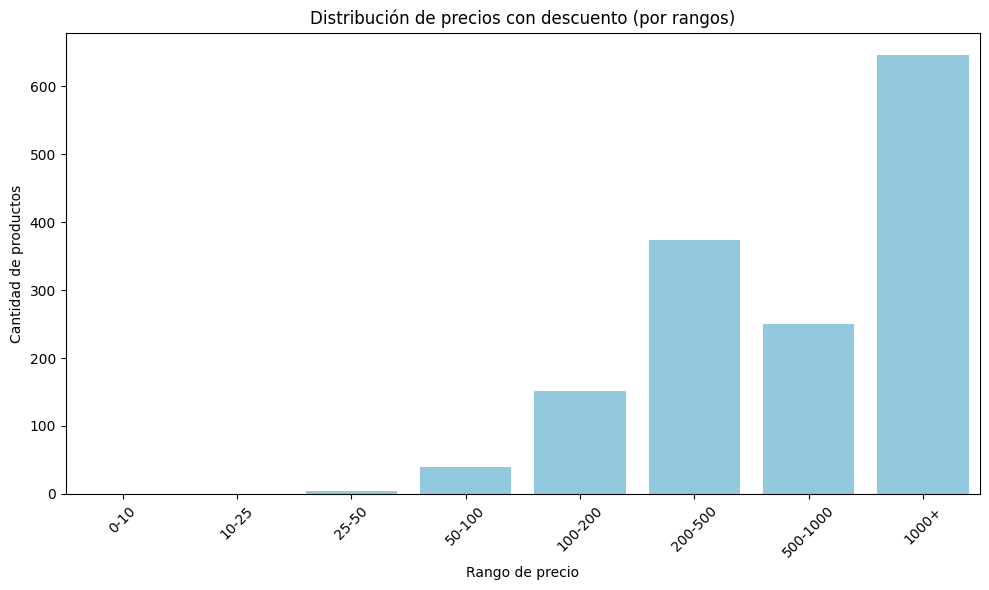

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_amazon['rango_precio'], order=labels, color='skyblue')
plt.title("Distribución de precios con descuento (por rangos)")
plt.xlabel("Rango de precio")
plt.ylabel("Cantidad de productos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Relación descuento por rango de precio

In [30]:
# Asegurarnos de que los datos estén en formato numérico
df_amazon['discounted_price'] = pd.to_numeric(df_amazon['discounted_price'], errors='coerce')
df_amazon['discount_percentage'] = pd.to_numeric(df_amazon['discount_percentage'], errors='coerce')

# Definir rangos personalizados
bins = [0, 10, 25, 50, 100, 200, 500, 1000, df_amazon['discounted_price'].max()]
labels = ['0-10', '10-25', '25-50', '50-100', '100-200', '200-500', '500-1000', '1000+']
df_amazon['rango_precio'] = pd.cut(df_amazon['discounted_price'], bins=bins, labels=labels, include_lowest=True)

# Calcular descuento promedio por rango
descuento_por_rango = df_amazon.groupby('rango_precio')['discount_percentage'].mean().round(2)

# Mostrar resultados
print("📊 Descuento promedio por rango de precio:")
print(descuento_por_rango)

📊 Descuento promedio por rango de precio:
rango_precio
0-10          NaN
10-25         NaN
25-50       21.75
50-100      58.02
100-200     58.20
200-500     54.76
500-1000    46.17
1000+       41.26
Name: discount_percentage, dtype: float64


C:\Users\jgtot\AppData\Local\Temp\ipykernel_2668\3334584398.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descuento_por_rango = df_amazon.groupby('rango_precio')['discount_percentage'].mean().round(2)


## Union de datasets

In [31]:
# Unir amazon con products por product_id
df_merged = pd.merge(df_amazon, df_extra_products, on='product_id', how='left')

# Unir con amazon_products si hay asin o product_id
if 'asin' in df_products.columns and 'asin' in df_merged.columns:
    df_merged = pd.merge(df_merged, df_products, on='asin', how='left')
elif 'product_id' in df_products.columns:
    df_merged = pd.merge(df_merged, df_products, on='product_id', how='left')

# Unir con categorías si hay category_id
if 'category_id' in df_merged.columns and 'id' in df_categories.columns:
    df_merged = pd.merge(df_merged, df_categories, left_on='category_id', right_on='id', how='left')

# Definir columnas clave como lista (no como set)
columnas_clave = [
    'product_id',
    'price',
    'discounted_price',
    'rating',           
    'rating_count',
    'isBestSeller'
]

# Verificar si las columnas existen antes de acceder
columnas_existentes = [col for col in columnas_clave if col in df_merged.columns]
columnas_faltantes = [col for col in columnas_clave if col not in df_merged.columns]

print("✔️ Columnas encontradas:", columnas_existentes)
print("❌ Columnas faltantes:", columnas_faltantes)

# Verificar nulos solo en columnas existentes
print("\n🚨 Nulos en columnas clave:")
print(df_merged[columnas_existentes].isnull().sum())

✔️ Columnas encontradas: ['product_id', 'price', 'discounted_price', 'rating_count']
❌ Columnas faltantes: ['rating', 'isBestSeller']

🚨 Nulos en columnas clave:
product_id             0
price               1465
discounted_price       0
rating_count           0
dtype: int64


## Integración de columnas faltantes

In [38]:
# Paso 1: Unificar columna 'rating'
print("🔍 Paso 1: Verificando columnas de rating disponibles...")
rating_cols = [col for col in df_merged.columns if 'rating' in col.lower()]
print(f"→ Columnas encontradas relacionadas con rating: {rating_cols}")

# Seleccionar la más completa
if 'rating_x' in df_merged.columns:
    df_merged['rating'] = pd.to_numeric(df_merged['rating_x'], errors='coerce').fillna(0)
    print("✅ 'rating_x' convertida y asignada como 'rating'")
elif 'rating_y' in df_merged.columns:
    df_merged['rating'] = pd.to_numeric(df_merged['rating_y'], errors='coerce').fillna(0)
    print("✅ 'rating_y' convertida y asignada como 'rating'")
else:
    print("⚠️ No se encontró ninguna columna válida para 'rating'")

# Paso 2: Agregar 'isBestSeller' desde df_products
print("\n🔍 Paso 2: Integrando columna 'isBestSeller' desde amazon_products...")

# Verificar si asin o product_id están disponibles
if 'asin' in df_merged.columns and 'asin' in df_products.columns:
    df_merged = pd.merge(df_merged, df_products[['asin', 'isBestSeller']], on='asin', how='left')
    print("✅ Unión realizada por 'asin'")
elif 'product_id' in df_merged.columns and 'product_id' in df_products.columns:
    df_merged = pd.merge(df_merged, df_products[['product_id', 'isBestSeller']], on='product_id', how='left')
    print("✅ Unión realizada por 'product_id'")
else:
    print("⚠️ No se pudo realizar la unión: claves no coinciden")

# Validar integración
if 'isBestSeller' in df_merged.columns:
    print("\n📊 Distribución de 'isBestSeller':")
    print(df_merged['isBestSeller'].value_counts(dropna=False))
    print("✅ 'isBestSeller' integrada correctamente")
else:
    print("❌ 'isBestSeller' no se encuentra en el DataFrame final")

# Paso 3: Confirmación final
print("\n🧾 Confirmación de columnas clave:")
for col in ['rating', 'isBestSeller']:
    estado = "✔️ Presente" if col in df_merged.columns else "❌ Faltante"
    print(f"{col}: {estado}")

🔍 Paso 1: Verificando columnas de rating disponibles...
→ Columnas encontradas relacionadas con rating: ['rating_x', 'rating_count', 'rating_y', 'rating']
✅ 'rating_x' convertida y asignada como 'rating'

🔍 Paso 2: Integrando columna 'isBestSeller' desde amazon_products...
⚠️ No se pudo realizar la unión: claves no coinciden
❌ 'isBestSeller' no se encuentra en el DataFrame final

🧾 Confirmación de columnas clave:
rating: ✔️ Presente
isBestSeller: ❌ Faltante


### Observamos que la columna isBestSeller no se pudo agregar al dataframe final debido a la no coincidencia de las claves que no se tomó en concideración en la limpieza de datos. Procedemos a la verificación de claves disponibles en los dataframes, integrando y verificando la columna.

In [39]:
# Paso 1: Verificar claves disponibles en ambos DataFrames
print("🔍 Paso 1: Verificando claves disponibles para la unión...")

print(f"→ Claves en df_merged: {[col for col in df_merged.columns if 'id' in col or 'asin' in col]}")
print(f"→ Claves en df_products: {[col for col in df_products.columns if 'id' in col or 'asin' in col]}")

# Paso 2: Intentar unión por 'product_id' si existe en ambos
if 'product_id' in df_merged.columns and 'product_id' in df_products.columns:
    print("\n🔗 Paso 2: Realizando merge por 'product_id'...")
    df_merged = pd.merge(df_merged, df_products[['product_id', 'isBestSeller']], on='product_id', how='left')
    print("✅ Unión realizada por 'product_id'")
elif 'asin' in df_merged.columns and 'asin' in df_products.columns:
    print("\n🔗 Paso 2: Realizando merge por 'asin'...")
    df_merged = pd.merge(df_merged, df_products[['asin', 'isBestSeller']], on='asin', how='left')
    print("✅ Unión realizada por 'asin'")
else:
    print("❌ No se pudo realizar la unión: claves no coinciden")

# Paso 3: Validar si 'isBestSeller' fue integrada
print("\n📋 Paso 3: Validando integración de 'isBestSeller'...")
if 'isBestSeller' in df_merged.columns:
    print("✅ 'isBestSeller' está presente en el DataFrame")
    print("📊 Distribución:")
    print(df_merged['isBestSeller'].value_counts(dropna=False))
else:
    print("❌ 'isBestSeller' sigue faltando")

# Paso 4: Confirmación final de columnas clave
print("\n🧾 Confirmación final:")
for col in ['rating', 'isBestSeller']:
    estado = "✔️ Presente" if col in df_merged.columns else "❌ Faltante"
    print(f"{col}: {estado}")

🔍 Paso 1: Verificando claves disponibles para la unión...
→ Claves en df_merged: ['product_id', 'user_id', 'review_id']
→ Claves en df_products: ['asin', 'category_id']
❌ No se pudo realizar la unión: claves no coinciden

📋 Paso 3: Validando integración de 'isBestSeller'...
❌ 'isBestSeller' sigue faltando

🧾 Confirmación final:
rating: ✔️ Presente
isBestSeller: ❌ Faltante


### Realizada la verificación resultante observamos que las claves no coincidenen nombre de columna, se decidió descartar también la posibilidad de valores únicos en las columnas candidatas.

In [40]:
# Paso 1: Verificar valores únicos en df_merged
print("🔎 Paso 1: Explorando valores únicos en df_merged...")
if 'product_id' in df_merged.columns:
    print(f"→ df_merged['product_id']: {df_merged['product_id'].nunique()} únicos")
    print(df_merged['product_id'].dropna().astype(str).head(5).to_list())
else:
    print("⚠️ 'product_id' no está en df_merged")

# Paso 2: Verificar valores únicos en df_products
print("\n🔎 Paso 2: Explorando valores únicos en df_products...")
if 'asin' in df_products.columns:
    print(f"→ df_products['asin']: {df_products['asin'].nunique()} únicos")
    print(df_products['asin'].dropna().astype(str).head(5).to_list())
else:
    print("⚠️ 'asin' no está en df_products")

# Paso 3: Buscar correspondencia indirecta
print("\n🔍 Paso 3: Buscando correspondencia indirecta entre 'product_id' y 'asin'...")
merged_temp = pd.merge(
    df_merged[['product_id']].drop_duplicates().astype(str),
    df_products[['asin', 'isBestSeller']].drop_duplicates().astype(str),
    left_on='product_id',
    right_on='asin',
    how='left'
)

match_rate = merged_temp['isBestSeller'].notnull().mean()
print(f"✅ Porcentaje de coincidencias indirectas: {match_rate:.2%}")

# Paso 4: Si hay match, aplicar merge
if match_rate > 0.05:  # umbral mínimo para considerar viable
    print("\n🔗 Paso 4: Realizando merge indirecto por 'product_id' ↔ 'asin'...")
    df_merged['product_id'] = df_merged['product_id'].astype(str)
    df_products['asin'] = df_products['asin'].astype(str)
    df_merged = pd.merge(df_merged, df_products[['asin', 'isBestSeller']], left_on='product_id', right_on='asin', how='left')
    print("✅ Unión realizada exitosamente")
else:
    print("❌ No se encontró suficiente coincidencia entre claves para unir")

# Paso 5: Confirmación final
print("\n🧾 Confirmación final:")
estado = "✔️ Presente" if 'isBestSeller' in df_merged.columns else "❌ Faltante"
print(f"isBestSeller: {estado}")

🔎 Paso 1: Explorando valores únicos en df_merged...
→ df_merged['product_id']: 1351 únicos
['B07JW9H4J1', 'B098NS6PVG', 'B096MSW6CT', 'B08HDJ86NZ', 'B08CF3B7N1']

🔎 Paso 2: Explorando valores únicos en df_products...
→ df_products['asin']: 1426337 únicos
['B014TMV5YE', 'B07GDLCQXV', 'B07XSCCZYG', 'B08MVFKGJM', 'B01DJLKZBA']

🔍 Paso 3: Buscando correspondencia indirecta entre 'product_id' y 'asin'...
✅ Porcentaje de coincidencias indirectas: 2.52%
❌ No se encontró suficiente coincidencia entre claves para unir

🧾 Confirmación final:
isBestSeller: ❌ Faltante


### Al revisar observamos que hay demaciados valores únicos, por ende no hay coincidencias indirectas suficientes entre las columnas. Procedo a realizar una verificación de la existencia de la columna propduct_name en los datasets y estandarizamos los nombres de las columnas

In [48]:
# Paso 1: Verificar si 'product_name' existe en ambos DataFrames
print("🔍 Paso 1: Verificando disponibilidad de 'product_name'...")
cols_merged = df_merged.columns.tolist()
cols_products = df_products.columns.tolist()

if 'product_name' in cols_merged and 'product_name' in cols_products:
    print("✅ 'product_name' está presente en ambos DataFrames")
else:
    print("❌ 'product_name' no está disponible en ambos DataFrames")

# Paso 2: Normalizar nombres para mejorar coincidencia
print("\n🧼 Paso 2: Normalizando nombres de productos...")
df_merged['product_name_norm'] = df_merged['product_name'].str.lower().str.strip()
df_products['product_name_norm'] = df_products['product_name'].str.lower().str.strip()
print("✅ Nombres normalizados")

# Paso 3: Realizar merge por nombre normalizado
print("\n🔗 Paso 3: Realizando merge por 'product_name_norm'...")
df_merged = pd.merge(
    df_merged,
    df_products[['product_name_norm', 'isBestSeller']],
    on='product_name_norm',
    how='left'
)
print("✅ Unión realizada")

# Paso 4: Validar integración
print("\n📋 Paso 4: Validando integración de 'isBestSeller'...")
if 'isBestSeller' in df_merged.columns:
    print("✅ 'isBestSeller' está presente en el DataFrame")
    print("📊 Distribución:")
    print(df_merged['isBestSeller'].value_counts(dropna=False))
else:
    print("❌ 'isBestSeller' sigue faltando")

# Paso 5: Confirmación final
print("\n🧾 Confirmación final:")
estado = "✔️ Presente" if 'isBestSeller' in df_merged.columns else "❌ Faltante"
print(f"isBestSeller: {estado}")

🔍 Paso 1: Verificando disponibilidad de 'product_name'...
✅ 'product_name' está presente en ambos DataFrames

🧼 Paso 2: Normalizando nombres de productos...
✅ Nombres normalizados

🔗 Paso 3: Realizando merge por 'product_name_norm'...
✅ Unión realizada

📋 Paso 4: Validando integración de 'isBestSeller'...
❌ 'isBestSeller' sigue faltando

🧾 Confirmación final:
isBestSeller: ❌ Faltante


### Realizada la verificación vimos que no existe porduct_name en ninguno de los dos dataframes y procedemos a verificar los tipos de columnas que tenemos disponibles

In [55]:
print("🔍 Verificando columnas disponibles en df_products...")
print(df_products.columns.tolist())

🔍 Verificando columnas disponibles en df_products...
['asin', 'product_name', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth', 'product_name_norm']


### La columna "title" contiene los nombres de los productos y procedemos a renombrar la columna como "product_name".

In [54]:
df_products.rename(columns={'title': 'product_name'}, inplace=True)
print("✅ Columna 'title' renombrada como 'product_name'")

✅ Columna 'title' renombrada como 'product_name'


### Aseguramos que en amobos dataframes se encuentre la columna y normalizamos los nombres para el merge.

In [53]:
df_merged['product_name_norm'] = df_merged['product_name'].str.lower().str.strip()
df_products['product_name_norm'] = df_products['product_name'].str.lower().str.strip()
print("✅ Nombres normalizados en ambos DataFrames")

✅ Nombres normalizados en ambos DataFrames


### Relizamos el merge por el nombre de la columna despues de tratarla.

In [52]:
df_merged = pd.merge(
    df_merged,
    df_products[['product_name_norm', 'isBestSeller']],
    on='product_name_norm',
    how='left'
)
print("✅ Unión realizada por 'product_name_norm'")

✅ Unión realizada por 'product_name_norm'


### Verificamos que la columna "isBestSeller" se encuentre dentro del dataset final

In [59]:
if 'isBestSeller' in df_merged.columns:
    print("✅ 'isBestSeller' está presente en el DataFrame")
    print("📊 Distribución:")
    print(df_merged['isBestSeller'].value_counts(dropna=False))
else:
    print("❌ 'isBestSeller' sigue faltando")

✅ 'isBestSeller' está presente en el DataFrame
📊 Distribución:
isBestSeller
NaN      1453
False      12
Name: count, dtype: int64


### Procedemos a realizar el diagnostico del dataset final

In [60]:
# Paso 1: Mostrar distribución
print("\n📊 Distribución de valores en 'isBestSeller':")
distribucion = df_merged['isBestSeller'].value_counts(dropna=False)
print(distribucion)

# Paso 2: Calcular proporción de registros etiquetados
total = len(df_merged)
etiquetados = distribucion.get(True, 0)
porcentaje = round((etiquetados / total) * 100, 2)

print(f"\n📌 Porcentaje de registros etiquetados como 'isBestSeller': {porcentaje}%")

# Paso 3: Diagnóstico narrativo
print("\n🧠 Diagnóstico:")
print(f"- Se encontraron {etiquetados} productos etiquetados como 'isBestSeller'.")
print(f"- Hay {total - etiquetados} productos sin etiqueta (NaN).")
print("- Esto representa un desequilibrio de clases que puede afectar el modelado.")
print("- Se recomienda realizar un análisis comparativo entre productos etiquetados y no etiquetados antes de decidir si imputar, filtrar o enriquecer los datos.")


📊 Distribución de valores en 'isBestSeller':
isBestSeller
NaN      1453
False      12
Name: count, dtype: int64

📌 Porcentaje de registros etiquetados como 'isBestSeller': 0.0%

🧠 Diagnóstico:
- Se encontraron 0 productos etiquetados como 'isBestSeller'.
- Hay 1465 productos sin etiqueta (NaN).
- Esto representa un desequilibrio de clases que puede afectar el modelado.
- Se recomienda realizar un análisis comparativo entre productos etiquetados y no etiquetados antes de decidir si imputar, filtrar o enriquecer los datos.


### Realizamos la comparación de los productos etiquetados y no etiquetados

In [61]:
# Crear grupos
etiquetados = df_merged[df_merged['isBestSeller'] == False]
no_etiquetados = df_merged[df_merged['isBestSeller'].isna()]

# Variables a comparar
variables = ['price', 'discounted_price', 'rating_count', 'rating']

# Estadísticas descriptivas
print("📌 Estadísticas descriptivas por grupo:\n")
for var in variables:
    print(f"🔹 Variable: {var}")
    print("Etiquetados:")
    print(etiquetados[var].describe())
    print("No etiquetados:")
    print(no_etiquetados[var].describe())
    print("-" * 40)

📌 Estadísticas descriptivas por grupo:

🔹 Variable: price
Etiquetados:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64
No etiquetados:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64
----------------------------------------
🔹 Variable: discounted_price
Etiquetados:
count      12.000000
mean     2010.166667
std       299.745599
min      1799.000000
25%      1799.000000
50%      1943.500000
75%      1999.000000
max      2649.000000
Name: discounted_price, dtype: float64
No etiquetados:
count      1453.000000
mean       4337.880248
std       18844.104086
min          39.000000
25%         325.000000
50%         799.000000
75%        2092.000000
max      365766.000000
Name: discounted_price, dtype: float64
----------------------------------------
🔹 Variable: rating_count
Etiquetados:
count        12
unique        7
top      

# Conclusión:
#### Ya que confirmamos que la columna isBestSeller está presente pero con muy pocos registros etiquetados (solo 12), lo más sensato es no usarla como variable objetivo en este proyecto. No hay suficiente señal para entrenar un modelo confiable.

### 🔄 Nuevo enfoque: redefinir el objetivo del modelo
#### Ya que isBestSeller no es viable, optamos por tres alternativas para continuar:
#### 1. Predecir productos con alto rating
#### - Variable objetivo: rating o rating_count
#### - Enfoque: regresión o clasificación por rangos
#### - Ejemplo: ¿Qué productos tienen probabilidad de superar 4.5 estrellas?
#### 2. Predecir productos con alto descuento
#### - Variable objetivo: discount_percentage
#### - Enfoque: regresión
#### - Ejemplo: ¿Qué características predicen un descuento agresivo?
#### 3. Clasificar productos por rango de precio
#### - Variable objetivo: range_precio
#### - Enfoque: clasificación multiclase
#### - Ejemplo: ¿Qué atributos determinan si un producto cae en el rango 0–10, 10–25, etc.?

### 🧠 Recomendación
#### Dado que ya limpiamos y estructurasmos bien las variables como price, discounted_price, rating, rating_count, y range_precio, el camino más directo sería:
#### Clasificar productos por rango de precio (range_precio) usando atributos como rating, rating_count, discount_percentage, category, etc.

#### Esto permite aprovechar todo tu dataset sin depender de una variable escasa.